In [1]:
!pip install kora -q
from kora import drive
drive.link_nbs()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.7 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/AI_Notebooks/SWIN')

In [ ]:
!huggingface-cli login    # logging by token --> [token in my Notion]

#### 0) Loading & preparing data

In [ ]:
!pip install datasets -q

In [5]:
import io
import torch
from torch import nn
from torch.utils.data import IterableDataset, DataLoader
from torchvision.datasets import ImageNet
from torchvision import transforms
from datasets import load_dataset
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
dset = load_dataset('imagenet-1k', split='train', streaming=True)

In [7]:
IMG_SIZE = 224                  # example image size - adjust as needed
MEAN = [0.485, 0.456, 0.406]    # standard ImageNet mean
STD = [0.229, 0.224, 0.225]     # standard ImageNet standard deviation

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),     # resize images
    transforms.ToTensor(),                       # to tensor (C, H, W) with values between 0 and 1
    transforms.Normalize(mean=MEAN, std=STD)     # normalize
])


def preprocess_image(image):
    try:
        # image = Image.open(io.BytesIO(image_bytes))
        image = image.convert("RGB") if image.mode != "RGB" else image
        image = transform(image)
        return image
    except Exception as e:
        print(f"Error processing image: {e}")
        return None  # or return a default/dummy tensor


class ImageNetIterableDataset(IterableDataset):
    def __init__(self, dataset, preprocess_fn):
        self.dataset = dataset
        self.preprocess_fn = preprocess_fn

    def __iter__(self):
        for example in self.dataset:
            try:
                image = self.preprocess_fn(example['image'])
                if image is not None:
                    yield {"pixel_values": image, "labels": torch.tensor(example['label'])}
            except Exception as e:
                print(f"Error during iteration: {e}")
                continue

    def __len__(self):
        return 1_281_167

processed_dset = ImageNetIterableDataset(dset, preprocess_image)

In [8]:
def collate_fn(examples):
    examples = [ex for ex in examples if ex is not None]
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.stack([example["labels"] for example in examples])

    return {"pixel_values": pixel_values, "labels": labels}

dataloader = DataLoader(processed_dset, batch_size=32, collate_fn=collate_fn)

In [ ]:
for epoch in range(1):
    for i, batch in enumerate(dataloader):
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]

        # pixel_values now contains a batch of preprocessed images as a tensor
        # labels contains the corresponding labels as a tensor

        # *** YOUR TRAINING CODE GOES HERE ***
        # Example: Print the shape of the pixel values and labels tensors
        print(f"Epoch: {epoch}, Batch: {i}")
        print(f"Pixel values shape: {pixel_values.shape}")  # Expected: [BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE]
        print(f"Labels shape: {labels.shape}")  # Expected: [BATCH_SIZE]

        # You would feed these tensors to your model for training
        # output = model(pixel_values)
        # loss = loss_function(output, labels)
        # ...

        if i > 5:  # Just process a few batches for demonstration
            break
    break  # Break after first epoch for demonstration

Epoch: 0, Batch: 0
Pixel values shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Epoch: 0, Batch: 1
Pixel values shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Epoch: 0, Batch: 2
Pixel values shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Epoch: 0, Batch: 3
Pixel values shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Epoch: 0, Batch: 4
Pixel values shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Epoch: 0, Batch: 5
Pixel values shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Epoch: 0, Batch: 6
Pixel values shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


#### 1) Take a look at data

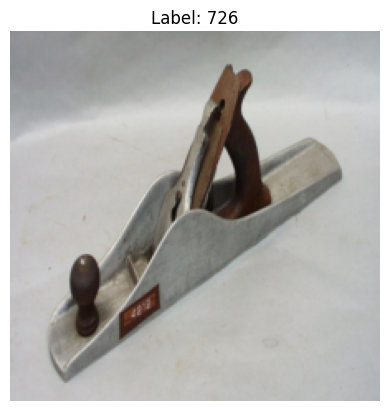

In [ ]:
sample = next(iter(processed_dset))

if sample is not None:
    image_tensor = sample["pixel_values"]

    # reverse previously applied normalization:
    reverse_norm = transforms.Compose([
        transforms.Normalize(mean = [ 0., 0., 0. ],
                             std = [ 1/0.229, 1/0.224, 1/0.225 ]),
        transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                             std = [ 1., 1., 1. ]),
        ])

    image_tensor = reverse_norm(image_tensor)

    image_tensor = image_tensor.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    image_np = image_tensor.numpy()  # Convert to numpy array

    plt.imshow(image_np)
    plt.title(f"Label: {sample['labels'].item()}") #Show label
    plt.axis('off')  # Hide the axis
    plt.show()
else:
    print("No image to display.")

In [ ]:
import urllib.request, json

CLASS_NAMES_URL = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"

with urllib.request.urlopen(CLASS_NAMES_URL) as url:
    class_names = json.loads(url.read().decode())

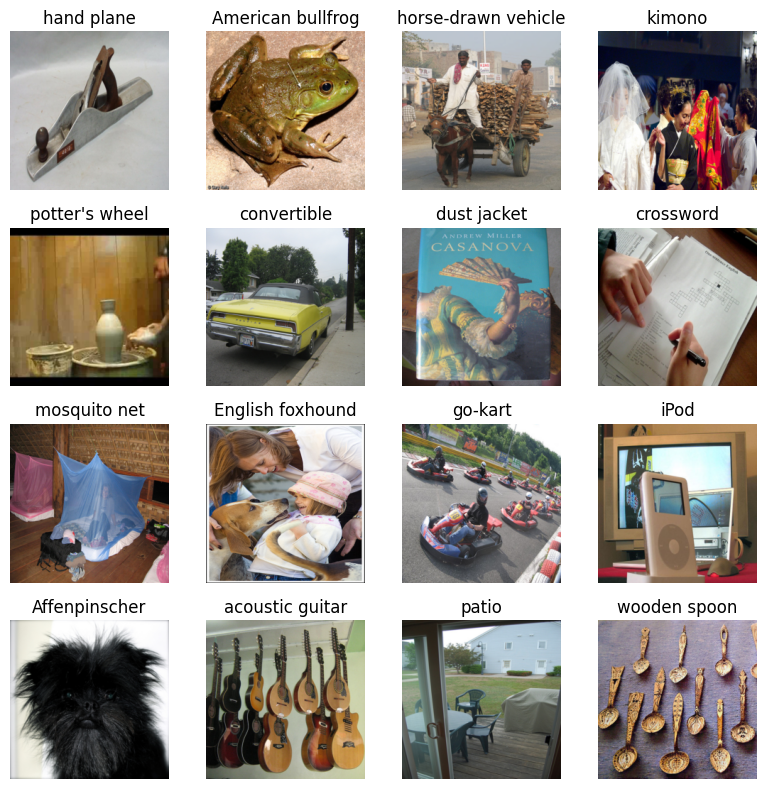

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))  # Create a 4x4 grid of subplots
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

i = 0
for i, batch in enumerate(dataloader):
    image_tensor = batch["pixel_values"][0]  # Get the image tensor from the batch
    label = batch["labels"][0].item()  # Get the label
    class_name = class_names[label]

    # If you had normalization in your transform, you'd need to reverse it:
    reverse_norm = transforms.Compose([
        transforms.Normalize(mean = [ 0., 0., 0. ],
                             std = [ 1/0.229, 1/0.224, 1/0.225 ]),
        transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                             std = [ 1., 1., 1. ]),
        ])
    image_tensor = reverse_norm(image_tensor)

    image_tensor = image_tensor.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    image_np = image_tensor.numpy()  # Convert to numpy array

    axes[i].imshow(image_np)
    axes[i].set_title(f"{class_name}")  # Set the title of the subplot
    axes[i].axis('off')  # Hide the axes
    i += 1
    if i >= 16: break

plt.tight_layout()  # Adjust subplot parameters for a tight layout
plt.show()

#### 2) Loading model + training

In [9]:
from model import SwinTransformer
import torch.optim as optim
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib import cm

In [10]:
swin_model = SwinTransformer()    # -> try with default parameters
optimizer = optim.Adam(swin_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def plot_values(values, subplot=None, **kwargs):
    if subplot:
        plt.subplot(*subplot)

    plt.plot(np.arange(len(values)) + 1, values, **kwargs)
    plt.xlabel("n_epoch")
    plt.legend()

device

device(type='cuda')

In [11]:
def train_model(model, train_loader, criterion, optimizer, n_epochs=10, device=torch.device("cpu"), verbose="text"):
    model = model.to(device)
    train_losses, train_accs = [], []

    for epoch in range(n_epochs):
        train_losses_per_batch = []
        train_accs_per_batch = []

        for batch in tqdm(train_loader):
            imgs = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            outputs = model(imgs.permute(0, 2, 3, 1))  # -> to (B, H, W, C)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_losses_per_batch.append(loss.item())
            train_accs_per_batch.append(0)    # to be implemented

        train_losses.append(np.mean(train_losses_per_batch))
        train_accs.append(np.mean(train_accs_per_batch))

        # stats output
        if verbose == "text":
            print(f'Epoch: {epoch + 1}, train loss: {train_losses[-1]}')
        elif verbose == "plots":
            clear_output(True)
            fig, (ax1, ax2) = plt.subplots(1, 2)
            fig.set_size_inches(11, 3)
            plot_values(train_losses, subplot=(1, 2, 1), label="Train CE", color="green")
            plot_values(train_accs, subplot=(1, 2, 2), label="Train Accuracy", color="maroon")
            plt.show()
        elif verbose is None:
            pass

# Save the model
# PATH = "./imagenet_model.pth"
# torch.save(model.state_dict(), PATH)

In [12]:
train_model(swin_model, dataloader, criterion, optimizer, n_epochs=5, device=device)

  0%|          | 0/40037 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
x = torch.arange(5).to(device)
x.device

device(type='cuda', index=0)

In [ ]:
a = torch.tensor(5)
a.to(x.device)

tensor(5, device='cuda:0')